### **Midterm Project:  Kaggle Competition Practice - Digit Recognizer**

In [ ]:
import os
import tensorflow as tf
from  tensorflow import keras
from keras.datasets import mnist
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras.utils.vis_utils import plot_model
import keras.layers as layers
from keras.models import Sequential
from keras.layers import Dense ,Flatten , Dropout , BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

As we can see we have 42000 images , each having 28*28 pixels.

The cloumn named "label" showing the class they belong to i.e entries in this column tell the number on image which corrensponds to sample data ( pixel values ) the rest of the column tell us the pixel values of the image

In [ ]:
mnist_data = pd.read_csv("mnist_numbers.csv")
mnist_data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**FEATURE AND LABEL EXTRACTION**

In [ ]:
data = mnist_data.drop(["label"] , axis=1 )
labels = mnist_data["label"]
data.shape

(42000, 784)

**TEST-TRAIN SPLIT**

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(data, labels,test_size=0.1 , random_state=42)

## **INPUT PIPELINE**

Here,

i)  **create_csv_files** function takes as input the original mnist dataset and splits it into multiple csv files . It outputs a list of directories where the csv files were created.

ii) **parse_text_to_tensors** takes as input each text line i.e each record , and then using tf.io.decode_csv this functions coverts converts the input records to tensors.

iii) And in the Final step of creating our input pipeline we use **final_dataset_from_csv_files** function . Within this function we first form dataset from the file paths that we have created using create_csv_files and then use a chain of transformations such as interleaving , shuffling , repeating and forming batches.

In [ ]:
def create_csv_files (dataset, csv_file_name_formatter, header=None, n_parts=1):
    length_dataset = len(dataset)
    working_directory_list = list()
    datasets_directory = os.path.join("mnist_numbers_dataset")
    os.makedirs(datasets_directory , exist_ok=True)
    dataset_directories = os.path.join(datasets_directory, "{}_data_part_{:01d}.csv")
    for file_number, row_indices in enumerate(np.array_split(np.arange(length_dataset), n_parts)):
        current_working_directory = dataset_directories.format(csv_file_name_formatter , file_number)
        working_directory_list.append(current_working_directory)
        with open(current_working_directory , "wt", encoding="utf-8") as current_file:
            if header is not None:
                current_file.write(header)
                current_file.write("\n")
            for row_index in row_indices:
                current_file.write(",".join([repr(column) for column in dataset[row_index]]))
                current_file.write("\n")
    return working_directory_list
def final_dataset_from_csv_files (filepaths , batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths)
    dataset=dataset.repeat(16)
    dataset = dataset.interleave( lambda filepath: tf.data.TextLineDataset(filepath).skip(1),cycle_length=5) 
    dataset = dataset.shuffle(buffer_size=28)
    dataset = dataset.map(parse_text_to_tensors, num_parallel_calls=5) 
    dataset = dataset.batch(batch_size) 
    return dataset.prefetch(1)

def parse_text_to_tensors(text_line):
    fields = tf.io.decode_csv(text_line , record_defaults=[0.]*X_train.shape[-1]+[tf.constant([], dtype=tf.float32)])
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return x,y

In [ ]:
parse_train_data = np.c_[X_train, y_train]
parse_valid_data = np.c_[X_valid, y_valid]
col_names=list()
for i in range(0,X_train.shape[1]):
    col_names = "pixel_"+ str(i)
    header = ",".join(col_names)
training_data_filepaths = create_csv_files(parse_train_data, "train", header, n_parts=25)
validation_data_filepaths = create_csv_files(parse_valid_data, "valid", header, n_parts=10)
training_data_filepaths
training_data = final_dataset_from_csv_files(training_data_filepaths)
validation_dataset = final_dataset_from_csv_files(validation_data_filepaths)
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## **Defining custom kernel initializer and custom activation function:**

i) In the **my_custom_initializer** function we basically define golorot normal initialization.We use this kernel initiaization the dense layer with 256 neurons.

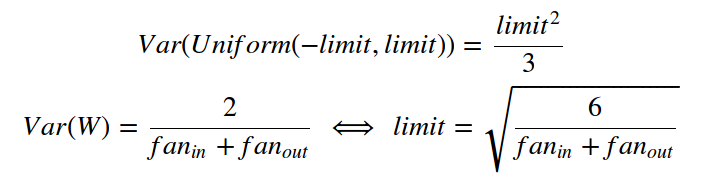



ii) In the **my_custom_LRelu** using a slope of 0.01 for negative values we implement the Leaky Relu activation function



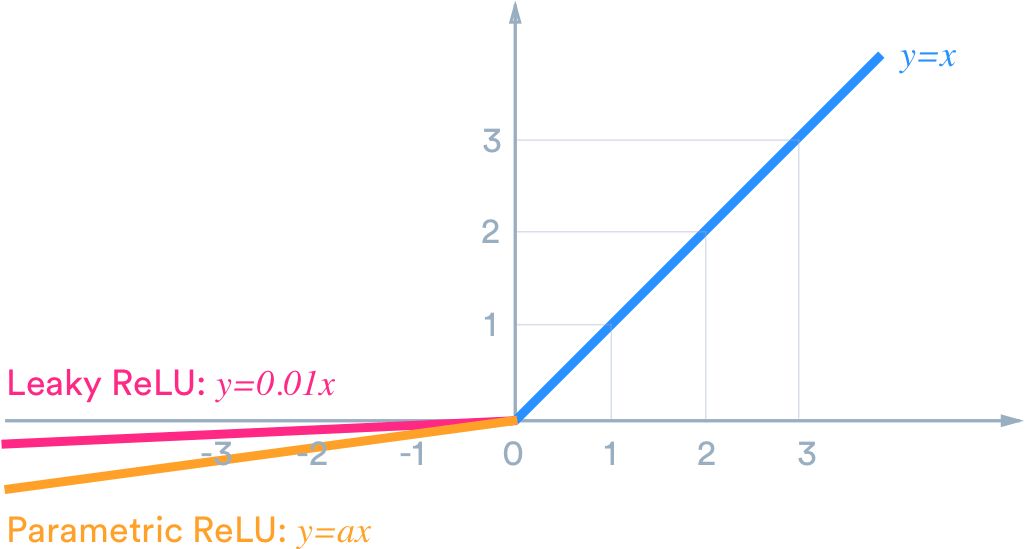



In [ ]:
def my_custom_kernel_initializer(shape,dtype=tf.float32):
            weights_stdeviation = tf.sqrt(2.0/(shape[0]+shape[1])) 
            weights = tf.random.normal(shape,weights_stdeviation)
            return weights         
def my_custom_LRelu (z,alpha=0.01):
    return tf.math.maximum(alpha*z,z)

# **Building Deep neural network**

i) In the neural network we have three convolution layers, four dense layers , two max pooling layers , two dropout layers and one batch normalization layer totalling upto 168938 parameters.

ii) The first Labmda layer act as a **standardization layer**

iii) The custom activation function was used in dense layers with 128,64 neurons and custom weight initialization function was used in th dense layers with 256 neurons.

iii) The model uses **Adam optimizer** at a **learning rate of 10^-3** , with the loss being mesaured using **sparse categorical cross entropy** as we have 10 classes in our MNIST data


In [ ]:
def build_model():
    model = Sequential()
    model.add( keras.layers.Lambda(lambda inputs: (inputs - np.mean(X_train, axis=0)) / (np.std(X_train, axis=0) + keras.backend.epsilon())))
    model.add(tf.keras.layers.Reshape((28,28,1)))
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', input_shape=(32,32,1), padding="same"))
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', input_shape=(32,32,1), padding="same"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2,2), activation='relu', padding='valid'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='valid' , strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=256, activation='tanh', kernel_initializer=my_custom_kernel_initializer))
    model.add(layers.Dense(units=128, activation=my_custom_LRelu))
    model.add(BatchNormalization())
    model.add(layers.Dense(units=64, activation=my_custom_LRelu))
    model.add(layers.Dense(units=10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [ ]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 784)               0         
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                        

In [ ]:
batch_size = 32
my_model=build_model()
history=my_model.fit(training_data, steps_per_epoch=len(X_train) // batch_size, epochs=16, validation_data=validation_dataset)

Epoch 1/16
1181/1181 [==============================] - 59s 49ms/step - loss: 0.4418 - accuracy: 0.8559 - val_loss: 0.0938 - val_accuracy: 0.9721
Epoch 2/16
1181/1181 [==============================] - 55s 47ms/step - loss: 0.1495 - accuracy: 0.9533 - val_loss: 0.0777 - val_accuracy: 0.9764
Epoch 3/16
1181/1181 [==============================] - 58s 49ms/step - loss: 0.1139 - accuracy: 0.9652 - val_loss: 0.0640 - val_accuracy: 0.9776
Epoch 4/16
1181/1181 [==============================] - 57s 48ms/step - loss: 0.0985 - accuracy: 0.9694 - val_loss: 0.0615 - val_accuracy: 0.9810
Epoch 5/16
1181/1181 [==============================] - 59s 50ms/step - loss: 0.0957 - accuracy: 0.9702 - val_loss: 0.0488 - val_accuracy: 0.9862
Epoch 6/16
1181/1181 [==============================] - 58s 49ms/step - loss: 0.0825 - accuracy: 0.9741 - val_loss: 0.0551 - val_accuracy: 0.9860
Epoch 7/16
1181/1181 [==============================] - 60s 51ms/step - loss: 0.0817 - accuracy: 0.9746 - val_loss: 0.0512 -

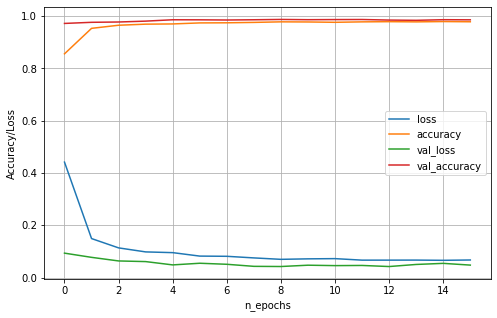



132/132 [==============================] - 1s 7ms/step - loss: 0.0481 - accuracy: 0.9860



Test loss: 0.048075202852487564
Test accuracy: 0.9859523773193359


In [ ]:
import matplotlib.pyplot as plt
print("\n")
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel("n_epochs")
plt.ylabel("Accuracy/Loss")
plt.show()
print("\n")
model_score = my_model.evaluate(X_valid, y_valid, verbose=1)
print('\n\n\nTest loss:', model_score[0])
print('Test accuracy:', model_score[1])

**So overall our neural network is having a test accuracy of 98.59% and test loss of 4.8% while we have a train accuacy of 97.85% and a train loss of 6.7%**

In [ ]:
test_data = pd.read_csv("mnist_numbers_test.csv")
l=my_model.predict(test_data)

875/875 [==============================] - 6s 6ms/step


In [ ]:
class_predictions = []
for i in l:
    class_predictions.append(np.where(i==np.max(i)))
outputclasses =[]
for i in class_predictions :
    outputclasses.append(list(i))
predictions =[]
final_predictions=[]
for j in outputclasses:
    predictions.append(list(j[0]))
for i in predictions:
    for j in i:
        final_predictions.append(j)

In [ ]:
print(final_predictions)

[2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1, 5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7, 8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0, 1, 9, 0, 1, 6, 5, 8, 8, 2, 8, 9, 9, 2, 3, 5, 4, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0, 6, 6, 1, 4, 3, 9, 7, 4, 0, 9, 2, 0, 7, 3, 0, 5, 0, 8, 0, 0, 4, 7, 1, 7, 1, 1, 3, 3, 3, 7, 2, 8, 6, 3, 8, 7, 7, 4, 3, 5, 6, 0, 0, 0, 3, 1, 3, 6, 4, 3, 4, 5, 5, 8, 7, 7, 2, 8, 4, 3, 5, 6, 5, 8, 7, 5, 7, 8, 3, 0, 4, 5, 1, 2, 7, 6, 3, 0, 2, 7, 8, 6, 1, 3, 7, 4, 1, 2, 4, 8, 5, 2, 4, 9, 2, 1, 6, 0, 6, 1, 4, 9, 6, 0, 9, 7, 6, 9, 1, 9, 0, 9, 9, 0, 8, 4, 6, 2, 0, 9, 3, 6, 3, 2, 1, 6, 3, 4, 2, 3, 1, 2, 2, 0, 4, 6, 1, 0, 0, 4, 9, 1, 7, 3, 2, 3, 8, 6, 8, 6, 2, 8, 5, 5, 4, 8, 3, 5, 9, 7, 1, 3, 8, 7, 5, 1, 4, 5, 6, 3, 3, 5, 7, 0, 6, 8, 3, 1, 6, 0, 6, 3, 9, 5, 1, 5, 8, 4, 0, 9, 2, 0, 5, 3, 7, 1, 9, 9, 5, 7, 7, 9, 9, 6, 3, 0, 3, 3, 6, 9, 8, 2, 6, 3, 7, 1, 4, 5, 8, 5, 9, 0, 0, 3, 8, 4, 1, 8, 4, 1, 1, 9, 8, 4, 5, 1, 5, 3, 6, 3, 1, 

**Creating a .csv file for kaggle submission using final predictions**

In [ ]:
import csv
with open('mnist_output.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(map(lambda x:[x],final_predictions))
    f.close()

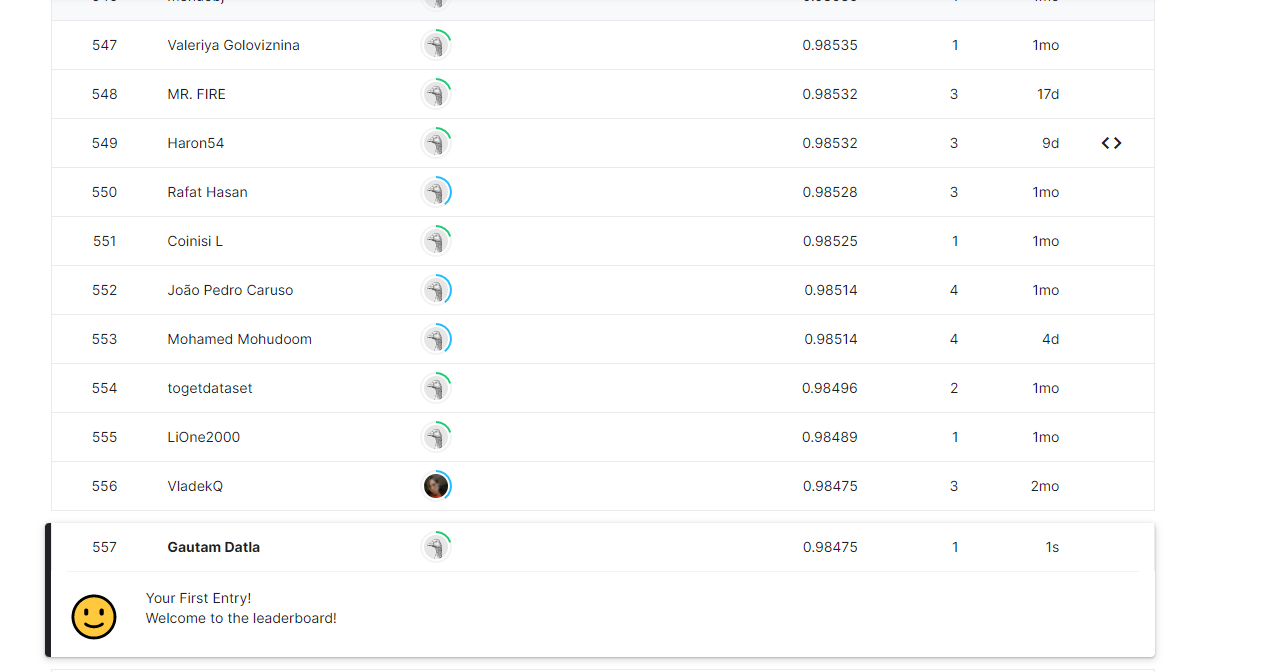



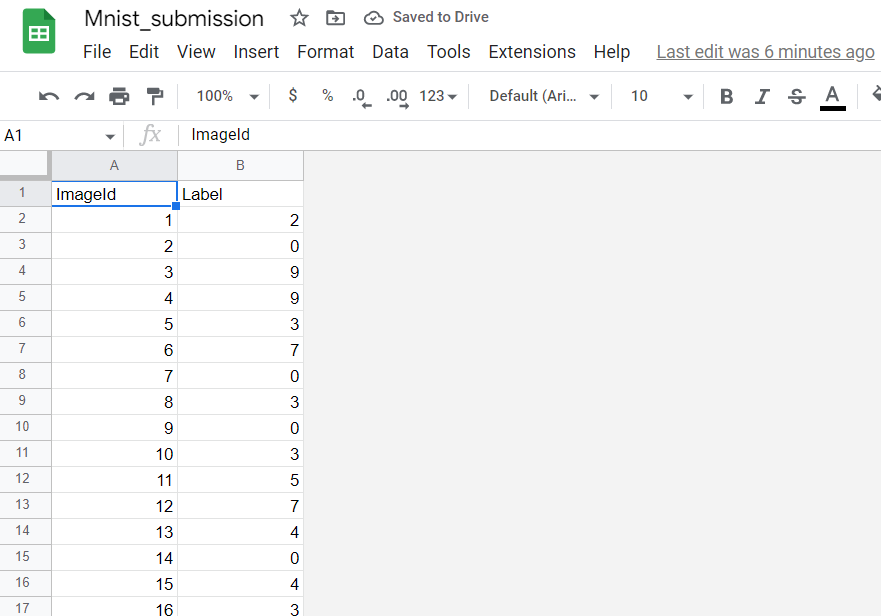